[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background

In this notebook, we are going to cover a technique called **Transfer Learning**, which generally refers to a process where a machine learning model is trained on one problem, and afterwards, it is reused in some way on a second (probably) related problem (Bengio, 2012). Specifically, in **deep learning**, this technique is used by training only some layers of the pre-trained network. Its promise is that the training will be more efficient and in the best of the cases the performance will be better compared to a model trained from scratch. For this example, we are using MobileNet architectures:

**MobileNet V1**, with its appearance in 2017, started a new path of deep learning research in computer vision: models that can run in **embedded devices**. This lead to several important works including ShuffleNet(V1 and V2), MNasNet, CondenseNet, and EffNet (among others). Due to its success, new versions of MobileNet have also appeared more recently. These new versions included new advances, such as **Inverted Residual Block** or the use of **Neural Architecture Search** for optimizing the creation of new neural components. **MobileNet Versions 2 (Sandler et al., 2018) and 3 (Howard et al., 2019)** are used as an example in this notebook.

In **agriculture**, since **weeds** compete with crops in the domain of space, light and nutrients, they are an important problem that can lead to a poorer harvest by farmers. To avoid this, weeds should be removed at every step of the growth, but especially at the initial stages. For that reason, identifying weeds accurately by deep learning has arisen as an important objective. Related to this, we can find the disease detection problem, where transfer learning has also been used. Among the most relevant recent works, we can find:

**Wang et al., (2017)** used transfer learning in order to obtain the best neural-based method for disease detection in plants. They extended the apple black rot images in the PlantVillage dataset, which were further annotated by botanists with four severity stages as ground truth. Then, they evaluated the performances of shallow networks trained from scratch and deep models fine-tuned by transfer learning. Their best model was the **VGG16** architecture trained with transfer learning, which yielded an overall accuracy of 90.4% on the hold-out test set. In **Mehdipour-Ghazi et al., (2017)**, the authors used the plant datasets of LifeCLEF 2015. Three popular deep learning architectures were evaluated: **GoogLeNet, AlexNet, and VGGNet**.  Their best combined system (a combination of GoogleNet and VGGNet) achieved an overall accuracy of 80% on the validation set and an overall inverse rank score of 0.752 on the official test set. In **Suh et al., (2018)**, the authors compared different transfer learning approaches in order to find a suitable approach for weed detection (volunteer potato). Their highest classification accuracy for **AlexNet** was 98.0%. Comparing different networks, their highest classification accuracy  was 98.7%, which was obtained with **VGG-19**. Additionally, all scenarios and pre-trained networks were feasible for real-time applications (classification time < 0.1 s). Another relevant study has been performed by **Kounalakis et al., (2019)** where they evaluated transfer learning by a combination of CNN-based feature extraction and linear classifiers to recognize rumex under real-world conditions. Their best system (**Inception_v1**+L2regLogReg) achieved an accuracy of 96.13 with a false positive rate of 3.62. In **Too et al., (2019)**, the authors used transfer learning achieving a performance of 99.75% with the **DenseNet** architecture. Finally, in **Espejo-Garcia et al., (2020)**, authors used transfer learning using agricultural datasets for pre-training neural networks, and afterwards, they fine-tuned the networks for classifying 4 species extracted from the **Eden Platform**. Their maximum performance was 99.54% by using the **Xception** architecture.

It is important to note that in this notebook, a technique integrating neural-network feature-extraction and "traditional" machine learning algorithms is used. This technique was used in **Kounalakis et al., (2019)** and **Espejo-Garcia et al., (2020)** and represents an extension over the previous Eden notebooks:
1. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-1.ipynb
2. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-2.ipynb
2. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/weeds_identification-transfer_learning-3.ipynb

#### Library Imports

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

#### Auxiliar functions
Check the docstrings for more information.

In [7]:
def get_class_names(image_datasets):
    '''
    Given the <image_datasets> data structure, it returns the names of the classes.

        Parameters:
            image_datasets (Dict[ImageFolder]): Pytorch data structure with the datasets info.

        Returns:
            class_names (List[String]): List containing the class of each image.
            processing.
    '''
    class_names = image_datasets['train'].classes
    return class_names

In [8]:
def get_image_datasets(data_path):
    '''
    Given the <data_path> where the data folders are stored, it returns a Pytorch-oriented
    data structure for further processing. Probably, DataLoader creation. 

        Parameters:
            data_path (string): The path where the folders are located.

        Returns:
            image_datasets (Dict[ImageFolder]): PyTorch Data Structure for further
            processing.
    '''
    # Data augmentation and normalization for training and validation
    # Depending on the Architectures evaluated the Resize + CenterCrop should change 
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224), # It depends on the archicture
            transforms.ColorJitter(0.1, 0.1, 0.1, 0.1), # Experimental purposes
            transforms.RandomHorizontalFlip(), # Data augmentation purposes
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224), # It depends on the archicture
            transforms.ColorJitter(0.1, 0.1, 0.1, 0.1), # Experimental purposes
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    image_datasets = {x: datasets.ImageFolder(os.path.join(data_path, x),
                                              data_transforms[x])
                      for x in ['train', 'val']}

    return image_datasets

In [9]:
def list_history_accs(history_accs):
    '''
    Given the list of accuracies <history_accs> returned by the training process, 
    it returns a version oriented for plotting.

        Parameters:
            history_accs (List[Tensor]): The list of accuracies.

        Returns:
            processed_history_accs (List[Float]): A version oriented for plotting.
    '''
    processed_history_accs = [acc_apoch.cpu().numpy().tolist() 
                                for acc_apoch in history_accs]
    return processed_history_accs

def plot_performances(performances):
    '''
    Given the list of performances (validation accuracies) and method-name <performances>, 
    it plots how the validation accuracy progressed during the training/validation process.

        Parameters:
            performances (List[Tuple]): The list of method-performance tuples.
    '''
    plt.title("Validation Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Validation Accuracy")
    for performance in performances:
        plt.plot(range(1,NUM_EPOCHS+1), list_history_accs(performance[1]), 
                 label=performance[0])
    plt.ylim((0.7,1.))
    plt.xticks(np.arange(1, NUM_EPOCHS+1, 1.0))
    plt.legend()
    plt.show()

def imshow(dataloaders, class_names):
    '''
    Given the <dataloaders> and a list with the name of the classes <class_names>,
    it displays a grid of shuffled sample images.

        Parameters:
            dataloaders (DataLoader): PyTorch structure for managing images.
            class_names (List[String]): The list of class names per image.
    '''
    images, labels = next(iter(dataloaders['train']))
    rows = 4
    columns = 4
    fig = plt.figure(figsize=(10,10))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    for i in range(16):
        fig.add_subplot(rows, columns, i+1)
        plt.title(class_names[labels[i]])
        img = images[i].numpy().transpose((1, 2, 0))
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.axis('off')
        plt.imshow(img)    
    plt.show()

In [10]:
def train_model(model, num_epochs=15):
    '''
    Given a PyTorch pre-trained model <model> and a number of epochs <num_epochs>, 
    it returns a trained (fine-tuned) model during those number of epochs and a 
    history of the validation accuracies.

        Parameters:
            model (Model): PyTorch ready-to-use model.
            num_epochs (Int): The number of epochs for fine-tuning the model.

        Returns:
            model (Model): Fine-tuned model.
            val_acc_history (List[Tensor]): List containing the history of 
            validation accuracies. It will need further processing for plotting.
    '''
    init_time = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    val_acc_history = []
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

    # Observe that all parameters are being optimized
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        # This is similar to Keras Train/val.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward step
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Batch statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            # Epoch statistics
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Save validation accuracy 
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                # Save the model ONLY if accuracy is higher
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    # Computing and Printing Training Time
    time_elapsed = time.time() - init_time
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    # Printing highest validation accuracy
    print('Best val Acc: {:4f}'.format(best_acc))
    print()

    # load best model weights for further reuse
    model.load_state_dict(best_model_wts)

    return model, val_acc_history

In [11]:
def get_mobilenet_architecture(version, pretrained, as_feature_extractor):
    '''
    This function returns a pre-trained Pytorch MobileNet architecture. Versions
    2 and 3-Large are available.

        Parameters:
            version (string): which MobileNet version to import (2 or 3 Large).
            pretrained (Boolean): Whether to use pre-trained weights or not.
            as_feature_extractor (Boolean): Whether to fine-tune the "convolutional" layers.

        Returns:
            model_ft (Model): MobileNet architecture ready for training.
    '''
    NUM_CLASSES = 4
    if version == "2":
        model_ft = models.mobilenet_v2(pretrained=True)
        if as_feature_extractor:
            for param in model_ft.parameters():
                param.requires_grad = False

        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs, NUM_CLASSES)
    elif version == "3":
        model_ft = models.mobilenet_v3_large(pretrained=pretrained)
        if as_feature_extractor:
            for param in model_ft.parameters():
                param.requires_grad = False

        num_ftrs = model_ft.classifier[3].in_features
        model_ft.classifier[3] = nn.Linear(num_ftrs, NUM_CLASSES)    

    model_ft = model_ft.to(device)

    return model_ft

#### Experimental Constants

In [12]:
BATCH_SIZE = 16
NUM_EPOCHS = 10
DATA_PATH = './pytorch_eden_data'
NUM_WORKERS = 4

#### Loading images and Data Loaders

In [13]:
image_datasets = get_image_datasets(data_path=DATA_PATH)

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                              shuffle=True, num_workers=NUM_WORKERS) for x in ['train', 'val']}

class_names = get_class_names(image_datasets)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#### Displaying some sample images

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


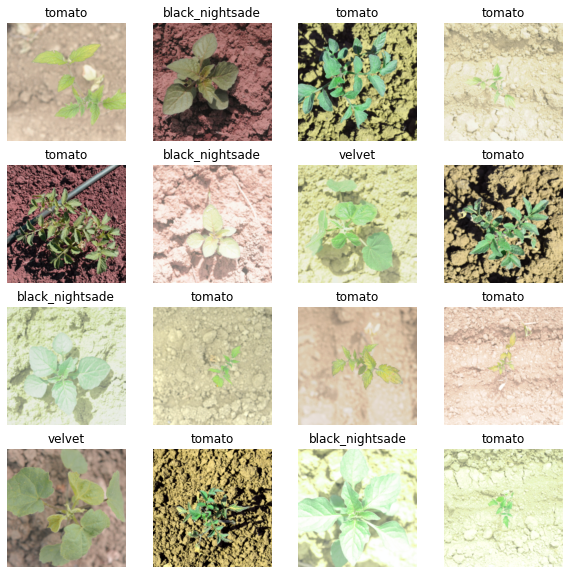

In [14]:
imshow(dataloaders, class_names)

#### Setting CUDA configuration if available

In [15]:
# Using CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Training / Fine-Tuning Models

In [16]:
# Loading and Training MobileNetV2 architectures
v2_model_ft = get_mobilenet_architecture(version="2",
                                         pretrained=True,
                                         as_feature_extractor=False)
v2_model_ft, v2ft_val_acc_history = train_model(v2_model_ft,
                                                num_epochs=NUM_EPOCHS)

v2_model_fe = get_mobilenet_architecture(version="2",
                                         pretrained=True,
                                         as_feature_extractor=True)
v2_model_fe, v2fe_val_acc_history = train_model(v2_model_fe,
                                                num_epochs=NUM_EPOCHS)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.0194 Acc: 0.6212
val Loss: 0.6131 Acc: 0.7371
Epoch 1/9
----------
train Loss: 0.3840 Acc: 0.9044
val Loss: 0.3083 Acc: 0.9014
Epoch 2/9
----------
train Loss: 0.1689 Acc: 0.9693
val Loss: 0.3208 Acc: 0.8967
Epoch 3/9
----------
train Loss: 0.0937 Acc: 0.9795
val Loss: 0.2432 Acc: 0.9202
Epoch 4/9
----------
train Loss: 0.0689 Acc: 0.9898
val Loss: 0.1794 Acc: 0.9531
Epoch 5/9
----------
train Loss: 0.0568 Acc: 0.9898
val Loss: 0.2567 Acc: 0.9202
Epoch 6/9
----------
train Loss: 0.0360 Acc: 0.9966
val Loss: 0.2364 Acc: 0.9296
Epoch 7/9
----------
train Loss: 0.0286 Acc: 1.0000
val Loss: 0.2421 Acc: 0.9249
Epoch 8/9
----------
train Loss: 0.0334 Acc: 0.9898
val Loss: 0.2244 Acc: 0.9437
Epoch 9/9
----------
train Loss: 0.0269 Acc: 0.9932
val Loss: 0.2181 Acc: 0.9390

Training complete in 20m 35s
Best val Acc: 0.953052

Epoch 0/9
----------
train Loss: 1.2794 Acc: 0.4061
val Loss: 0.9835 Acc: 0.6338
Epoch 1/9
----------
train Loss: 0.8258 Acc: 0.7474
val Loss: 0.5666 Acc: 0.

In [17]:
# Loading and Training MobileNetV3 (Large) architectures
v3_model_ft = get_mobilenet_architecture(version="3",
                                         pretrained=True,
                                         as_feature_extractor=False)
v3_model_ft, v3ft_val_acc_history = train_model(v3_model_ft,
                                                num_epochs=NUM_EPOCHS)

v3_model_fe = get_mobilenet_architecture(version="3",
                                         pretrained=True,
                                         as_feature_extractor=True)
v3_model_fe, v3fe_val_acc_history = train_model(v3_model_fe,
                                                num_epochs=NUM_EPOCHS)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth



Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.2732 Acc: 0.4573
val Loss: 1.2747 Acc: 0.4131
Epoch 1/9
----------
train Loss: 0.7452 Acc: 0.7918
val Loss: 0.9821 Acc: 0.7371
Epoch 2/9
----------
train Loss: 0.4747 Acc: 0.9010
val Loss: 0.7871 Acc: 0.8498
Epoch 3/9
----------
train Loss: 0.3361 Acc: 0.9420
val Loss: 0.6068 Acc: 0.9014
Epoch 4/9
----------
train Loss: 0.2459 Acc: 0.9420
val Loss: 0.4581 Acc: 0.9296
Epoch 5/9
----------
train Loss: 0.1620 Acc: 0.9795
val Loss: 0.3783 Acc: 0.9390
Epoch 6/9
----------
train Loss: 0.1231 Acc: 0.9761
val Loss: 0.3074 Acc: 0.9484
Epoch 7/9
----------
train Loss: 0.1207 Acc: 0.9795
val Loss: 0.2850 Acc: 0.9531
Epoch 8/9
----------
train Loss: 0.1092 Acc: 0.9829
val Loss: 0.2622 Acc: 0.9531
Epoch 9/9
----------
train Loss: 0.1073 Acc: 0.9863
val Loss: 0.2469 Acc: 0.9577

Training complete in 20m 44s
Best val Acc: 0.957746

Epoch 0/9
----------
train Loss: 1.2460 Acc: 0.4608
val Loss: 1.2708 Acc: 0.4601
Epoch 1/9
----------
train Loss: 0.8105 Acc: 0.8498
val Loss: 1.0362 Acc: 0.

#### Plotting Performances

In [20]:
# Preparing performances for being plotted
performances = [("MobileNetV2-Fine Tuning", v2ft_val_acc_history),
                ("MobileNetV2-Feature Extractor", v2fe_val_acc_history), 
                ("MobileNetV3-Fine Tuning", v3ft_val_acc_history), 
                ("MobileNetV3-Feature Extractor", v3fe_val_acc_history)]

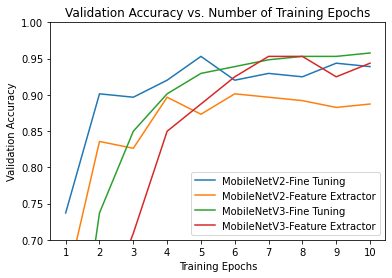

In [21]:
plot_performances(performances)

## Possible Extensions
1. Use a different pre-trained network (for instance, mobilenet_v3_small).
2. Try a different training approach where pre-trained weights are not loaded.
3. Try different learning rates (0.001 in this notebook) or even other optimization algorithms (e.g.: Adam) (SGD in this notebook).
4. Try different epochs and batch sizes.

## Bibliography
Bengio, Y., 2012. Deep Learning of Representations for Unsupervised and Transfer Learning. In: Journal of Machine Learning Research; 17–37.

Wang, G., Sun, Y., Wang, J., (2017). Automatic Image-Based Plant Disease Severity Estimation Using Deep Learning. Computational Intelligence and Neuroscience; 2017:8.

Mehdipour-Ghazi, M., Yanikoglu, B.A., & Aptoula, E. (2017). Plant identification using deep neural networks via optimization of transfer learning parameters. Neurocomputing, 235, 228-235.

Suh, H.K., IJsselmuiden, J., Hofstee, J.W., van Henten, E.J., (2018). Transfer learning for the classification of sugar beet and volunteer potato under field conditions. Biosystems Engineering; 174:50–65.

Kounalakis T., Triantafyllidis G. A., Nalpantidis L., (2019). Deep learning-based visual recognition of rumex for robotic precision farming. Computers and Electronics in Agriculture.

Too, E.C., Yujian, L., Njuki, S., & Ying-chun, L. (2019). A comparative study of fine-tuning deep learning models for plant disease identification. Comput. Electron. Agric., 161, 272-279.

Espejo-Garcia, B., Mylonas, N., Athanasakos, L., & Fountas, S., (2020). Improving
Weeds Identification with a Repository of Agricultural Pre-trained Deep Neural
Networks. Computers and Electronics in Agriculture; 175 (August).

Sandler, M., Howard, A.G., Zhu, M., Zhmoginov, A., & Chen, L. (2018). MobileNetV2: Inverted Residuals and Linear Bottlenecks. 2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition, 4510-4520.

Howard, A.G., Sandler, M., Chu, G., Chen, L., Chen, B., Tan, M., Wang, W., Zhu, Y., Pang, R., Vasudevan, V., Le, Q.V., & Adam, H. (2019). Searching for MobileNetV3. 2019 IEEE/CVF International Conference on Computer Vision (ICCV), 1314-1324.

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

https://www.oreilly.com/library/view/programming-pytorch-for/9781492045342/ch04.html